# Benchmarking spatial mapping of cell types in the LN

## Loading packages

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
cell2location

<module 'cell2location' from '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/cell2location/__init__.py'>

## 1. Loading cell2location results <a name="loading"></a>

In [3]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

run_name = 'CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)

adata_vis.obs[adata_vis.uns['mod']['fact_names']] = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## 2. Loading gold standard annotations results <a name="loading2"></a>

In [4]:
# read region annotation for each location
manual_GC_annot = pd.read_csv(f'{sp_results_folder}{run_name}/manual_GC_annot.csv', index_col=0)
manual_GC_annot['GC'][manual_GC_annot['GC'].isna()] = 'other'
manual_GC_annot['GC'].value_counts()

other    3657
GC        378
Name: GC, dtype: int64

In [5]:
ind = manual_GC_annot.index.isin(adata_vis.obs_names)
ind = manual_GC_annot.index[ind]
adata_vis = adata_vis[ind,:]
adata_vis.obs['supervised_region'] = manual_GC_annot.loc[ind, 'GC']

# remove other group
#adata_vis = adata_vis[~adata_vis.obs['supervised_region'].isin(['other']),:]

# read region annotations for each cell type
gold_standard = pd.read_csv(f'{sp_results_folder}{run_name}/gold_standard_annotation_subtypes_to_regions.csv',
                            index_col=0)
gold_standard = gold_standard.loc[gold_standard.isna().sum(1) == 0,]
gold_standard.index = [f'gold_standard_{i}' for i in gold_standard.index]

# remove other group
gold_standard = gold_standard.loc[~gold_standard['label'].isin(['other', 'T-cell zone']),:]

for ct in gold_standard.index:
    adata_vis.obs[ct] = adata_vis.obs['supervised_region'].isin([gold_standard.loc[ct, 'label']]).astype(float)
    
adata_vis.obs[gold_standard.index]

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,gold_standard_B_Cycling,gold_standard_B_GC_DZ,gold_standard_B_GC_LZ,gold_standard_B_GC_prePB,gold_standard_FDC,gold_standard_T_CD4+_TfH_GC
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTGTATTACACG-1,0.0,0.0,0.0,0.0,0.0,0.0


... storing 'supervised_region' as categorical


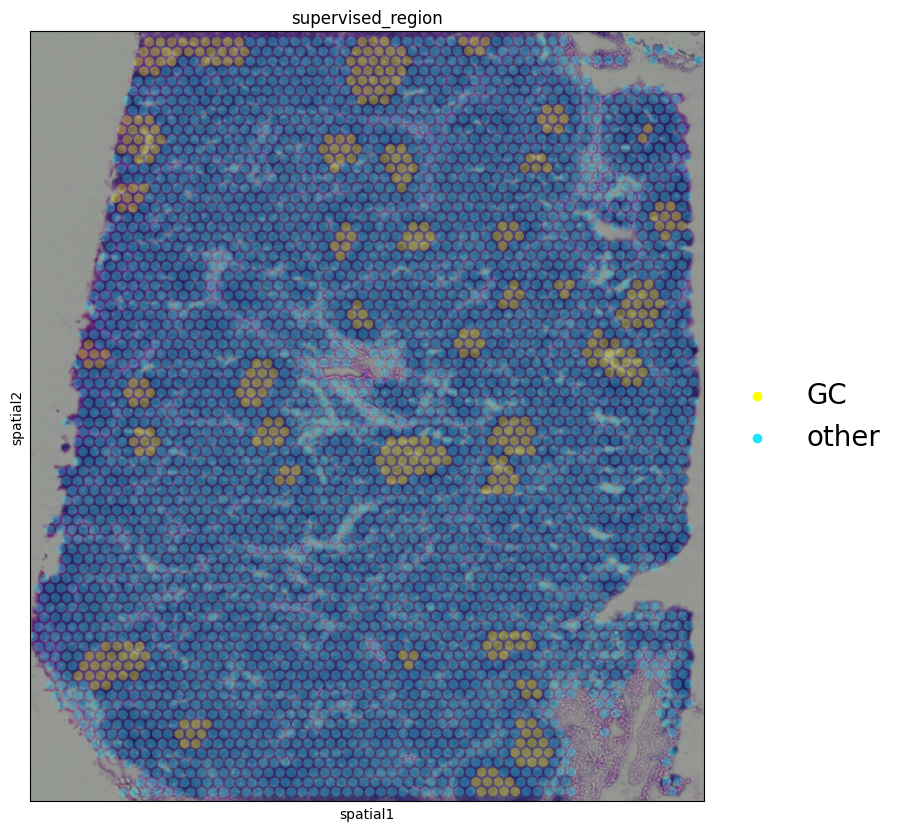

In [6]:
crop_x = [230, 1640]
crop_y = [150, 1760]

max_y = list(adata_vis.uns['spatial'].values())[0]['images']['hires'].shape[1]
crop_y = [max_y - i + 80 for i in crop_y]

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (10, 10), 'axes.facecolor': "black"}):
    sc.pl.spatial(adata_vis, cmap='magma',
                  color=['supervised_region'], ncols=4, 
                  size=1.3, img_key='hires', 
                  alpha_img=1, alpha=0.3,
                  frameon=True, legend_fontsize=20,
                  crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', #save='benchmark_supervised_region.pdf',
                  palette=sc.pl.palettes.default_102
                 )

## Compare methods using PR-curves

In [7]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']


def compute_precision_recall(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = average_precision_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = precision_recall_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def compute_roc(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot ROC curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = roc_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = roc_auc_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = roc_auc_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = roc_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def plot_precision_recall(pos_cell_count, infer_cell_proportions,
                          title='', iso_f1_curves=False,
                          individual_cell_types=True,
                          save=None, mode='macro', curve='PR'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    :param title: plot title
    :param iso_f1_curves: plot iso curves for F1 score?
    :param individual_cell_types: show precision-recall curves for each cell type?
    """
    
    ### calculating ###
    if curve == 'PR':
        precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'Recall'
        ylabel = 'Precision'
        
    elif curve == 'ROC':
        recall, precision, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'FPR'
        ylabel = 'TPR'
        
    ### plotting ###
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    lines = []
    labels = []
    
    if iso_f1_curves:
        f_scores = np.linspace(0.2, 0.8, num=4)
        
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
    
    l, = plt.plot(recall["averaged"], precision["averaged"], color='navy', lw=2)
    lines.append(l)
    labels.append(f'{mode}-average {curve} (area = {round(average_precision["averaged"], 2)})')

    if individual_cell_types:
        for i, color in zip(infer_cell_proportions.columns, colors):
            l, = plt.plot(recall[i], precision[i], color='gold', lw=1)
            lines.append(l)
        labels.append(f'{curve} for individual cell types')



    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -.18), prop=dict(size=8))
    
    if save is not None:
        plt.savefig(save)

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.18),
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=3)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=3)
            
        
        lines.append(l)

        labels.append(method_title[i] + ' (area = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=14))

    #plt.show()
    return roc

In [8]:
from re import sub
col_ind = [sub('gold_standard_','',i) for i in gold_standard.index]

In [10]:
# read cell2location with cluster averages
run_name = 'LocationModelLinearDependentW_1experiments_34clusters_4039locations_10241genes_input_averages_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001'

aver_sp_data_file = f'{sp_results_folder}{run_name}/sp_with_clusters.h5ad'
aver_adata_vis = anndata.read(aver_sp_data_file)

aver_adata_vis.obs[aver_adata_vis.uns['mod']['fact_names']] = aver_adata_vis.uns['mod']['post_sample_q05']['spot_factors']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [16]:
pos_cell_count = adata_vis.obs[gold_standard.index].values

cell2loc = adata_vis.obs[adata_vis.uns['mod']['fact_names']]
#cell2loc = (cell2loc.T / cell2loc.sum(1)).T
results =  [cell2loc.loc[:, col_ind]] \
+ [aver_adata_vis.obs[aver_adata_vis.uns['mod']['fact_names']].loc[cell2loc.index, col_ind]]
names = ['regression'] + ['mean counts per cluster']

In [17]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001/plots/figures/'

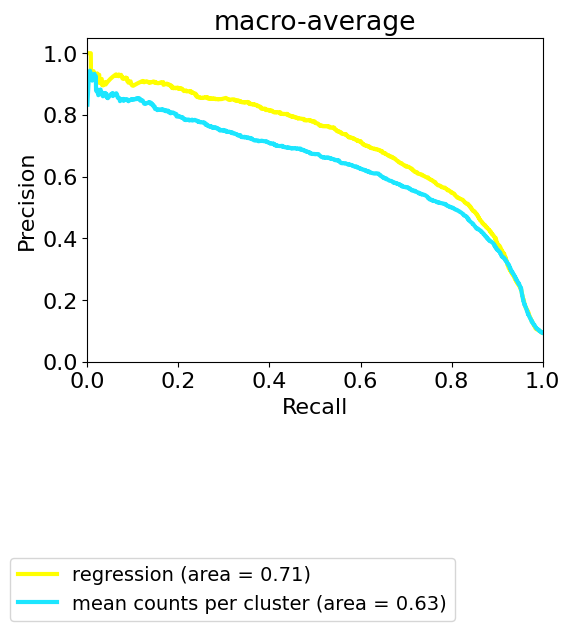

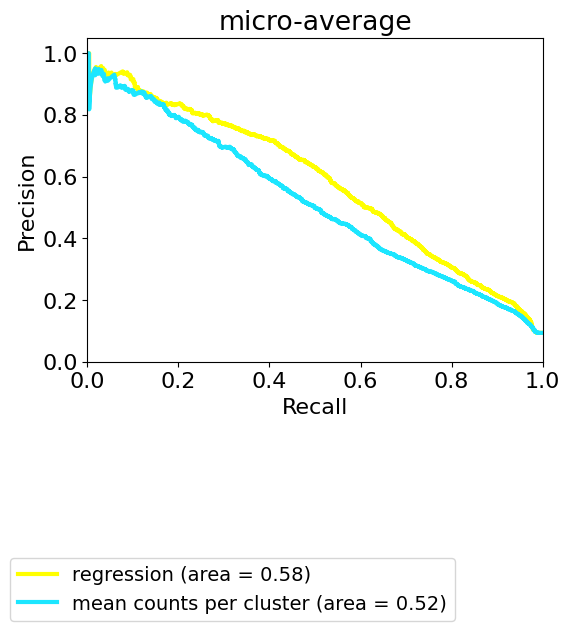

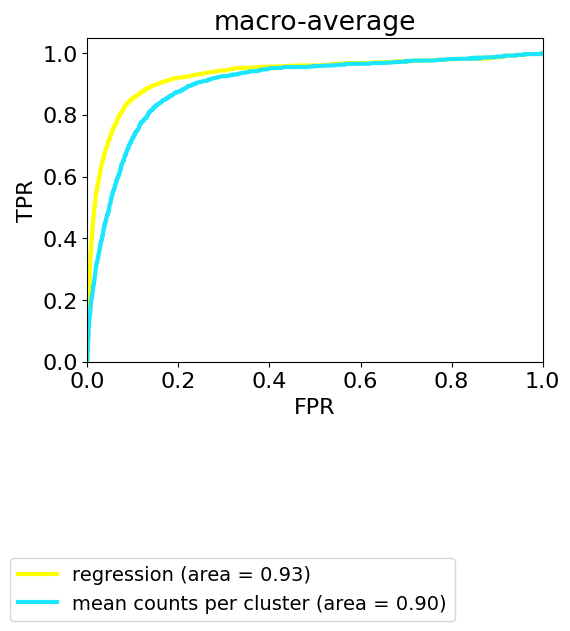

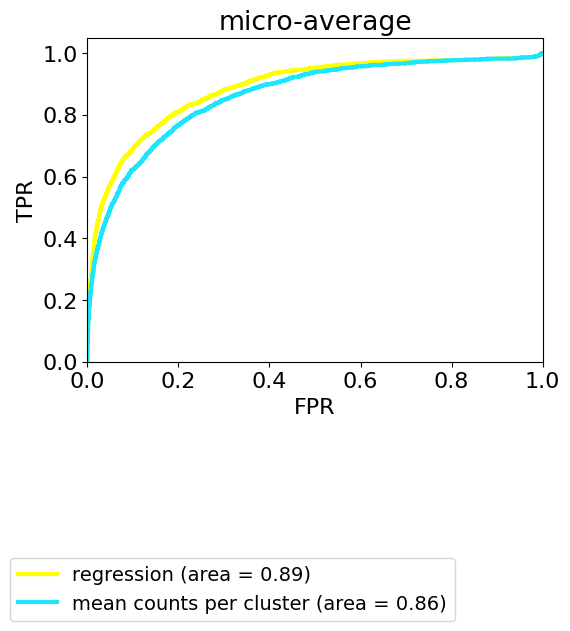

In [18]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (6,7.5), 'font.size': 16}):
    
    for c in ['PR', 'ROC']:
        for m in ['macro', 'micro']:
            compare_precision_recall(pos_cell_count, results,
                                     method_title=names, 
                                     legend_loc=(-0.17, -0.8),
                                     mode=m, curve=c)#,
                                     #colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
            plt.tight_layout()
            plt.title(f'{m}-average')
            plt.savefig(f'{fig_path}/{c}_NB_vs_averages_{m}average.pdf')
            plt.show()

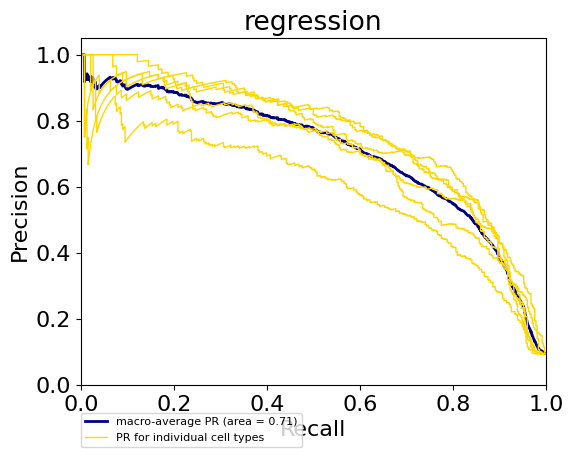

In [19]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (6,5.5), 'font.size': 16}):
    plot_precision_recall(pos_cell_count, results[0], title=names[0])

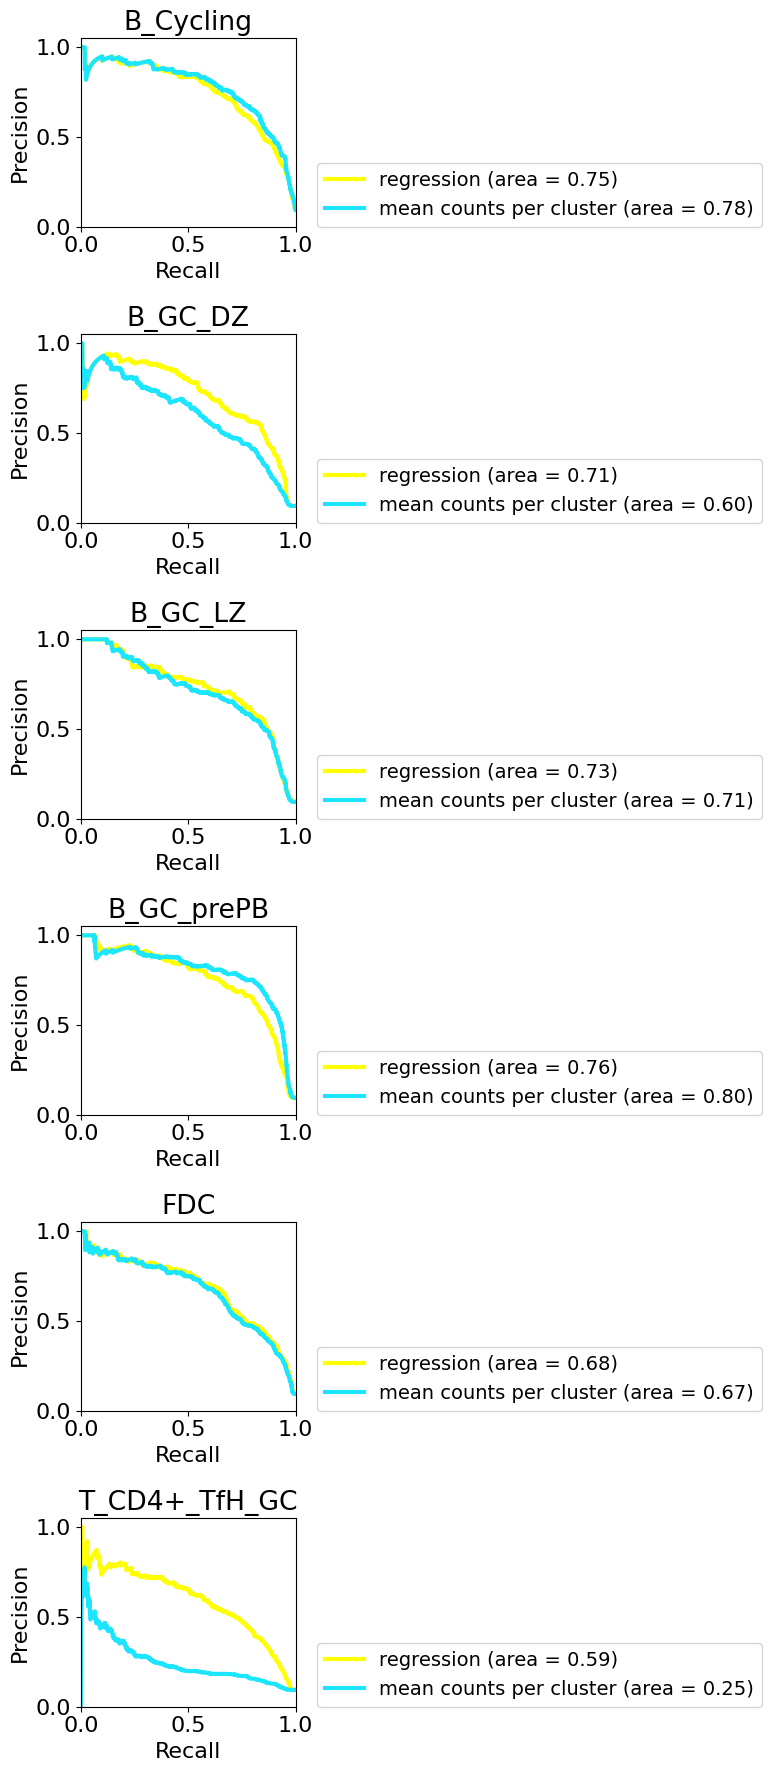

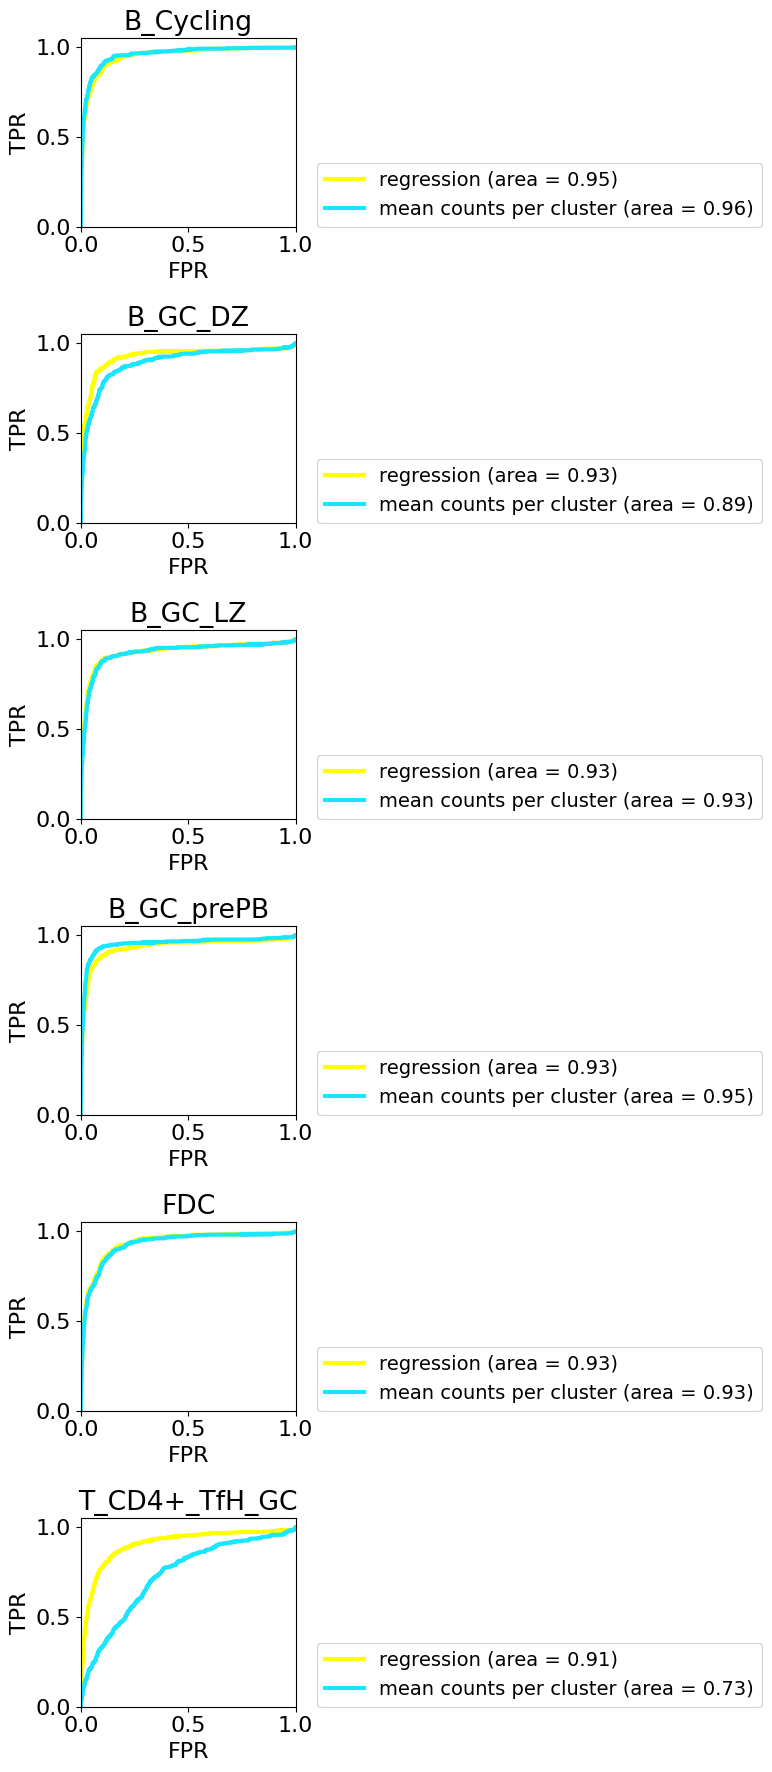

In [20]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (8,18), 'font.size': 16}):

    for c in ['PR', 'ROC']:
        for i, ct in enumerate(col_ind):

            plt.subplot(len(col_ind), 1, i+1)
            compare_precision_recall(pos_cell_count[:, np.isin(col_ind, ct)].reshape((pos_cell_count.shape[0], 1)), 
                                     [i[[ct]] for i in results],
                                     method_title=names, 
                                     legend_loc=(1.1, 0),
                                     curve=c
                                     #colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']
                                    )
            plt.tight_layout()
            plt.title(f'{ct}')
        plt.savefig(f'{fig_path}/{c}_comparison_all_cell_types.pdf')
        plt.show()

Modules and their versions used for this analysis

In [21]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass


sys 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.18.1
IPython.core.release 7.18.1
logging 0.5.1.2
zlib 1.0
traitlets 5.0.4
traitlets._version 5.0.4
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.18.1
pygments 2.7.1
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.7
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.3
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 19.0.2
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.2
zmq.sugar.constants 40302
zmq.sugar.version 19.0.2
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
tornado 6.0.4
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 